# 4차 프로그래밍 과제 - 20200852 허성연
* 문제 정의
    * 데이터 셋 “machine_data_update.csv ” 기반으로 CPU 성능에 관련된 다양한 특징들을 이용하여 CPU의 성능을 예측하는 회귀 분석 모델링하시오. 

# (1) ~ (3)

[데이터 탐색]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209 entries, 0 to 208
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   VendorName  209 non-null    object
 1   ModelName   209 non-null    object
 2   MYCT        209 non-null    int64 
 3   MMIN        209 non-null    int64 
 4   MMAX        209 non-null    int64 
 5   CACH        209 non-null    int64 
 6   CHMIN       209 non-null    int64 
 7   CHMAX       209 non-null    int64 
 8   PRP         209 non-null    int64 
 9   ERP         209 non-null    int64 
dtypes: int64(8), object(2)
memory usage: 16.5+ KB

[결측치 확인]
VendorName    0
ModelName     0
MYCT          0
MMIN          0
MMAX          0
CACH          0
CHMIN         0
CHMAX         0
PRP           0
ERP           0
dtype: int64

[변수들의 상관관계 확인]
PRP                1.000000
ERP                0.966472
MMAX               0.863004
MMIN               0.794931
CACH               0.662641
                

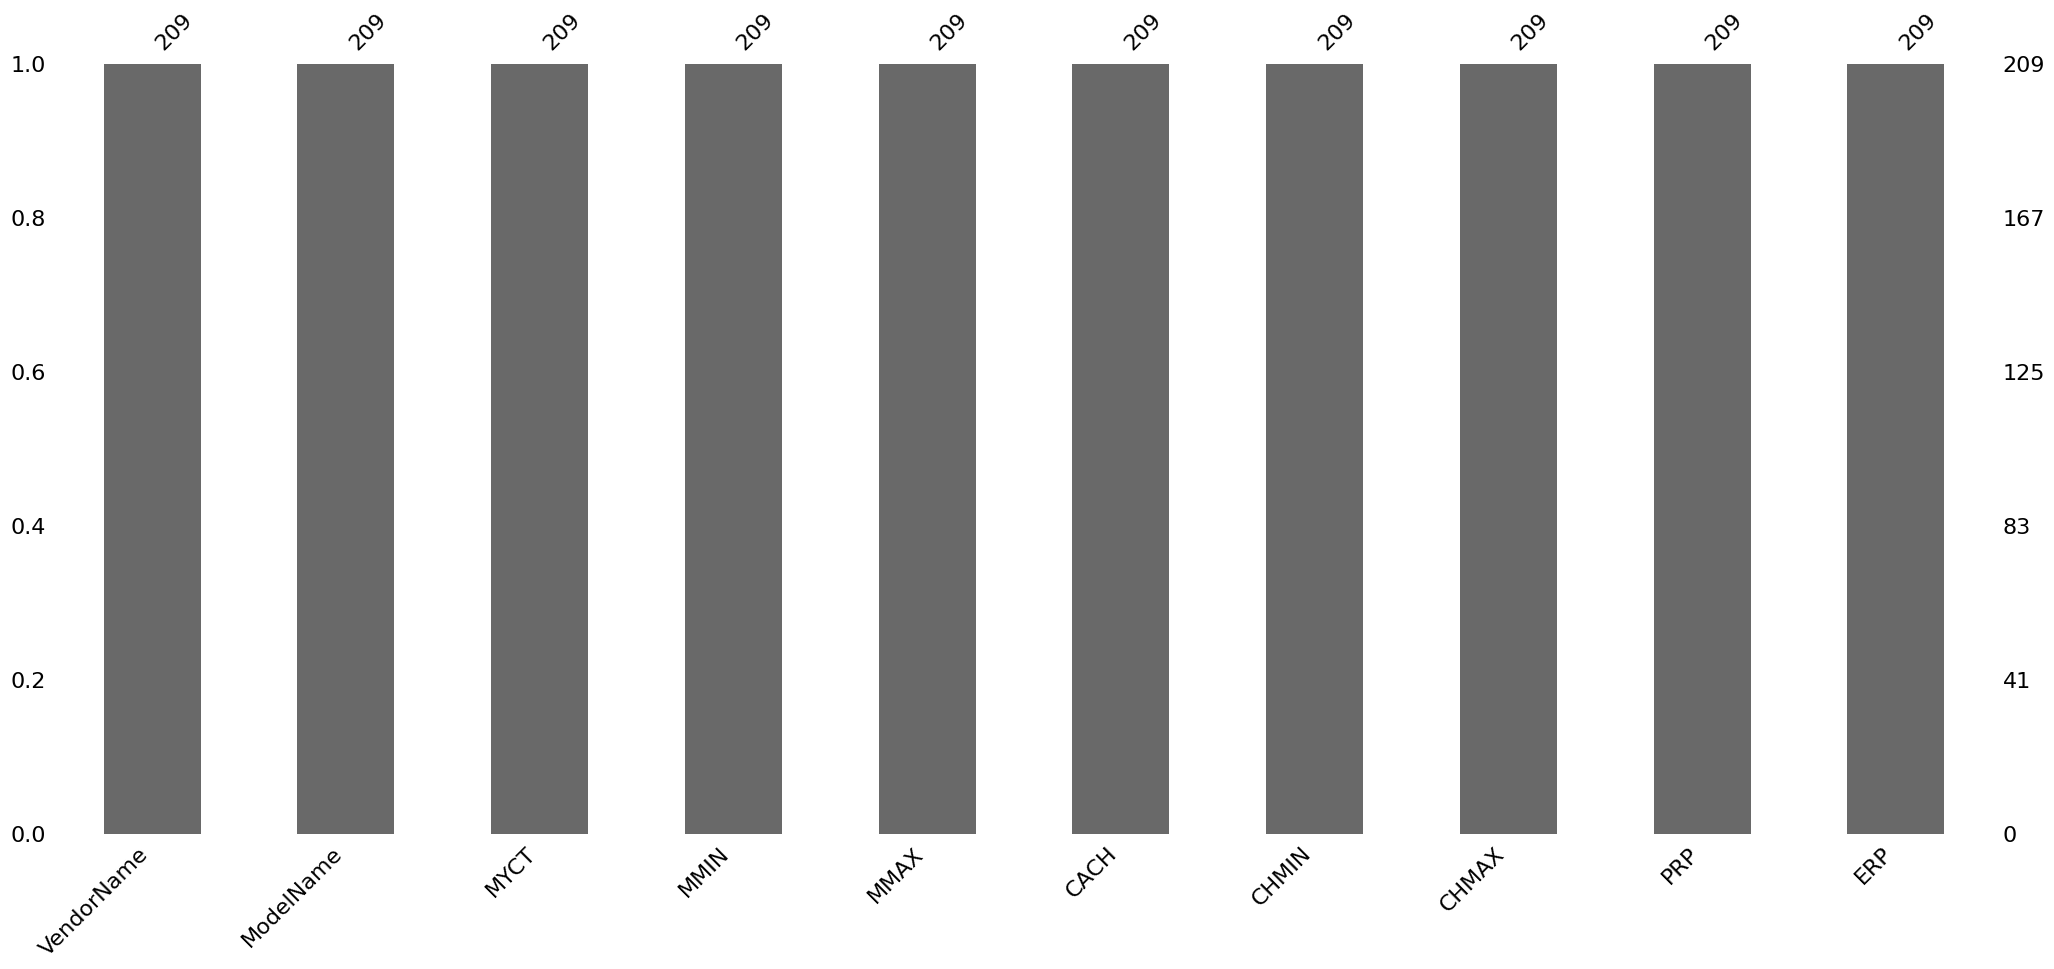

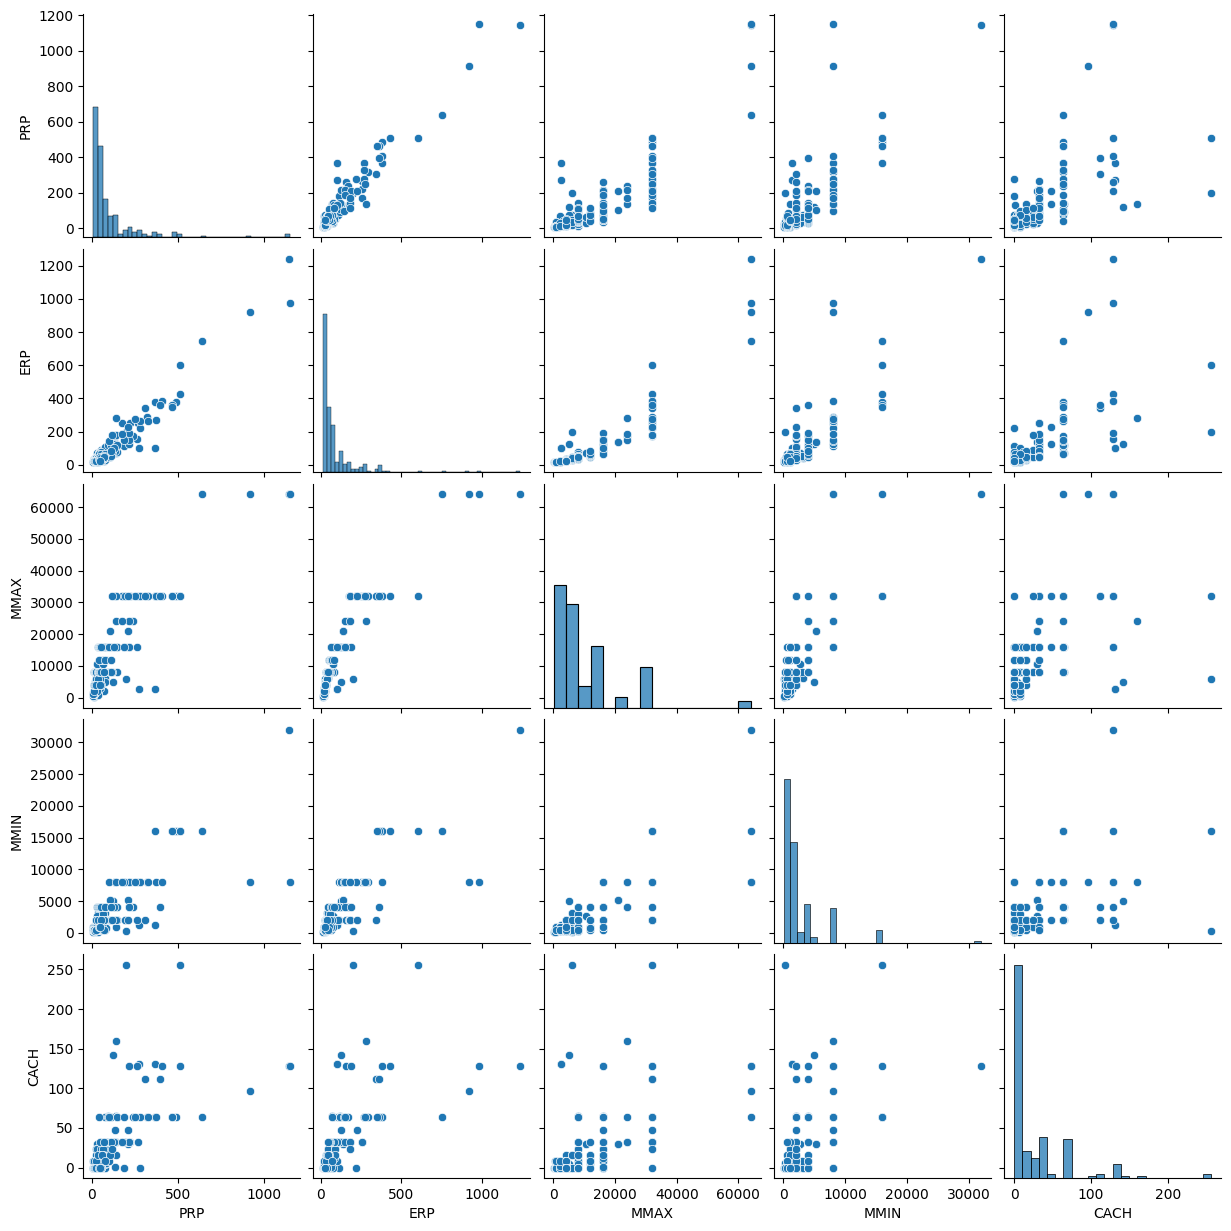


[최적 모델 학습 데이터 평가]
Train MSE: 1060.0886995073975
Train MAE: 20.027128576417034
Train R^2: 0.9588199307050851

[최적 모델 테스트 데이터 평가]
Test MSE: 1060.0886995073975
Test MAE: 20.027128576417034
Test R^2: 0.9588199307050851

[교차 검증]
CV MSE: 3157.8033302611766
CV MAE: 29.19542792940276
CV R^2: 0.850323331957617


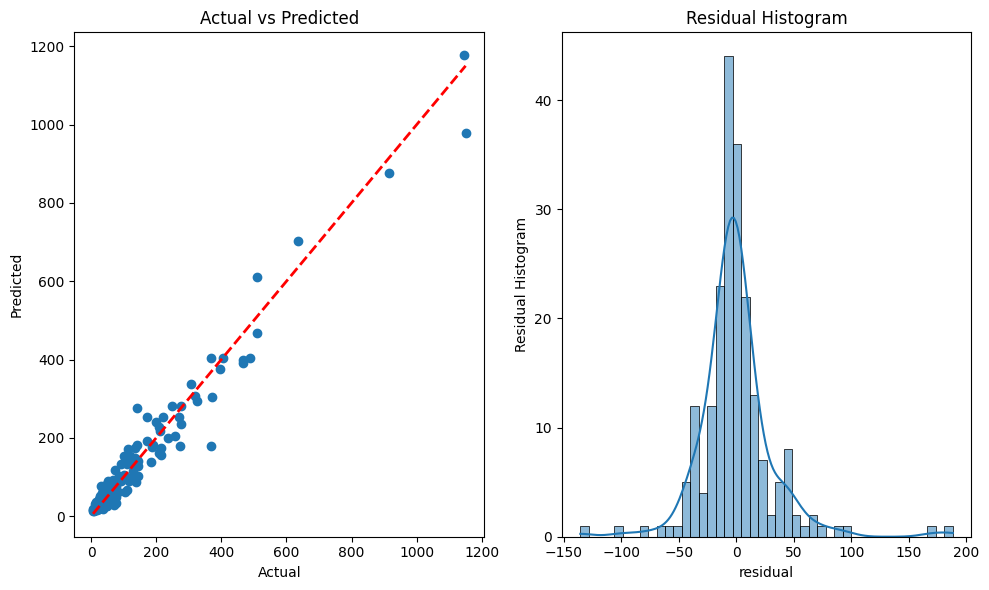

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msn
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDRegressor, LinearRegression, Ridge
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import VotingRegressor, GradientBoostingRegressor

# 1. 데이터 로드
cpu_data = pd.read_csv("machine.data_update.csv")

# 2. 데이터 탐색 및 시각화
print("[데이터 탐색]")
cpu_data.info()
msn.bar(cpu_data)

# 3-1. 결측치 확인
print("\n[결측치 확인]")
print(cpu_data.isna().sum())

# 3-2. 범주형 데이터 수치화
dum = pd.get_dummies(cpu_data.VendorName, prefix='v', dtype=float)
cpu_data = pd.concat([cpu_data.drop('VendorName', axis=1), dum], axis =1)

dum = pd.get_dummies(cpu_data['ModelName'], prefix='m',  dtype=float)
cpu_data = pd.concat([cpu_data.drop('ModelName', axis=1), dum], axis =1)

# 3-3. 중요 특징 추출
result = cpu_data.corr()['PRP']
result = np.abs(result).sort_values(ascending=False)
print(f"\n[변수들의 상관관계 확인]\n{result}")

# 3-4. 데이터 분포 시각화
data_features = ['PRP', 'ERP', 'MMAX', 'MMIN', 'CACH']
sns.pairplot(cpu_data[data_features])
plt.show()
print()

# 4.훈련 데이터와 테스트 데이터 분리
data_features = ['ERP', 'MMAX', 'MMIN', 'CACH']
X_train = cpu_data[data_features]
X_test = cpu_data[data_features]

y_train = cpu_data['PRP']
y_test = cpu_data['PRP']

# 6. 앙상블 기법으로 모델 생성 및 학습
#6-1. 전처리 파이프라인 생성
data_transformer = Pipeline(steps=[('scaler',StandardScaler()),])

preprocessor = ColumnTransformer(transformers=[('data', data_transformer,data_features),])

# 6-2. 개별 모델 정의
models = [('lr',LinearRegression()), ('sgd',SGDRegressor(random_state=42)), ('ridge', Ridge(random_state=42)), ('gbr',GradientBoostingRegressor(random_state=42))]

# 6-3. 앙상블 모델 정의
ensemble = VotingRegressor(estimators = models)

# 6-4. 모델 파이프라인 생성
model_pipeline = Pipeline(steps=[('preprocessor',preprocessor),('ensemble', ensemble),])

# 7. 하이퍼파라미터 튜닝
param_grid = {
    'ensemble__sgd__alpha':[0.001, 0.01], 
    'ensemble__sgd__max_iter':[1000, 2000],
    'ensemble__ridge__alpha': [10, 20],
    'ensemble__gbr__n_estimators': [100, 200],
    'ensemble__gbr__learning_rate': [0.01, 0.1],
}

# 8. 훈련 데이터 앙상블 학습 과정
grid_search_mse = GridSearchCV(model_pipeline, param_grid, cv = 5, scoring = "neg_mean_squared_error", return_train_score = True)
grid_search_mse.fit(X_train, y_train)

# 9-1.  최적 모델로 예측
best_model = grid_search_mse.best_estimator_

# 9-2. 최적 모델 성능 평가
train_pred = best_model.predict(X_train)
test_pred = best_model.predict(X_test)

train_mse = mean_squared_error(y_train, train_pred)
train_mae = mean_absolute_error(y_train, train_pred)
train_r2 = r2_score(y_train, train_pred)
print("[최적 모델 학습 데이터 평가]")
print(f"Train MSE: {train_mse}")
print(f"Train MAE: {train_mae}")
print(f"Train R^2: {train_r2}")

test_mse = mean_squared_error(y_test, test_pred)
test_mae = mean_absolute_error(y_test, test_pred)
test_r2 = r2_score(y_test, test_pred)
print("\n[최적 모델 테스트 데이터 평가]")
print(f"Test MSE: {test_mse}")
print(f"Test MAE: {test_mae}")
print(f"Test R^2: {test_r2}")

# 9-3. 교차 검증
cv_mses = cross_val_score(best_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
cv_mse = -cv_mses.mean()
print("\n[교차 검증]")
print(f"CV MSE: {cv_mse}")

cv_maes = cross_val_score(best_model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
cv_mae = -cv_maes.mean()
print(f"CV MAE: {cv_mae}")

cv_r2s = cross_val_score(best_model, X_train, y_train, cv=5, scoring='r2')
cv_r2 = cv_r2s.mean()
print(f"CV R^2: {cv_r2}")

# 10. 최적 모델 성능 시각화
# 10-1. 실제 vs 예측 비교
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.scatter(y_test, test_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')

#10-2. 잔차 히스토그램
residual = y_test - test_pred
plt.subplot(1, 2, 2)
sns.histplot(residual, kde=True)
plt.xlabel('residual')
plt.ylabel('Residual Histogram')
plt.title('Residual Histogram')
plt.tight_layout()
plt.show()

# (4)

               Model              Data          MSE        MAE       R^2
0  Linear Regression             Train     0.080122   0.168049  0.919878
1  Linear Regression              Test     0.248032   0.263921  0.913534
2  Linear Regression  Cross Validation     0.131817   0.190302  0.836798
3     Best_estimator             Train  1060.088700  20.027129  0.958820
4     Best_estimator              Test  1060.088700  20.027129  0.958820
5     Best_estimator  Cross Validation  3157.803330  29.195428  0.850323



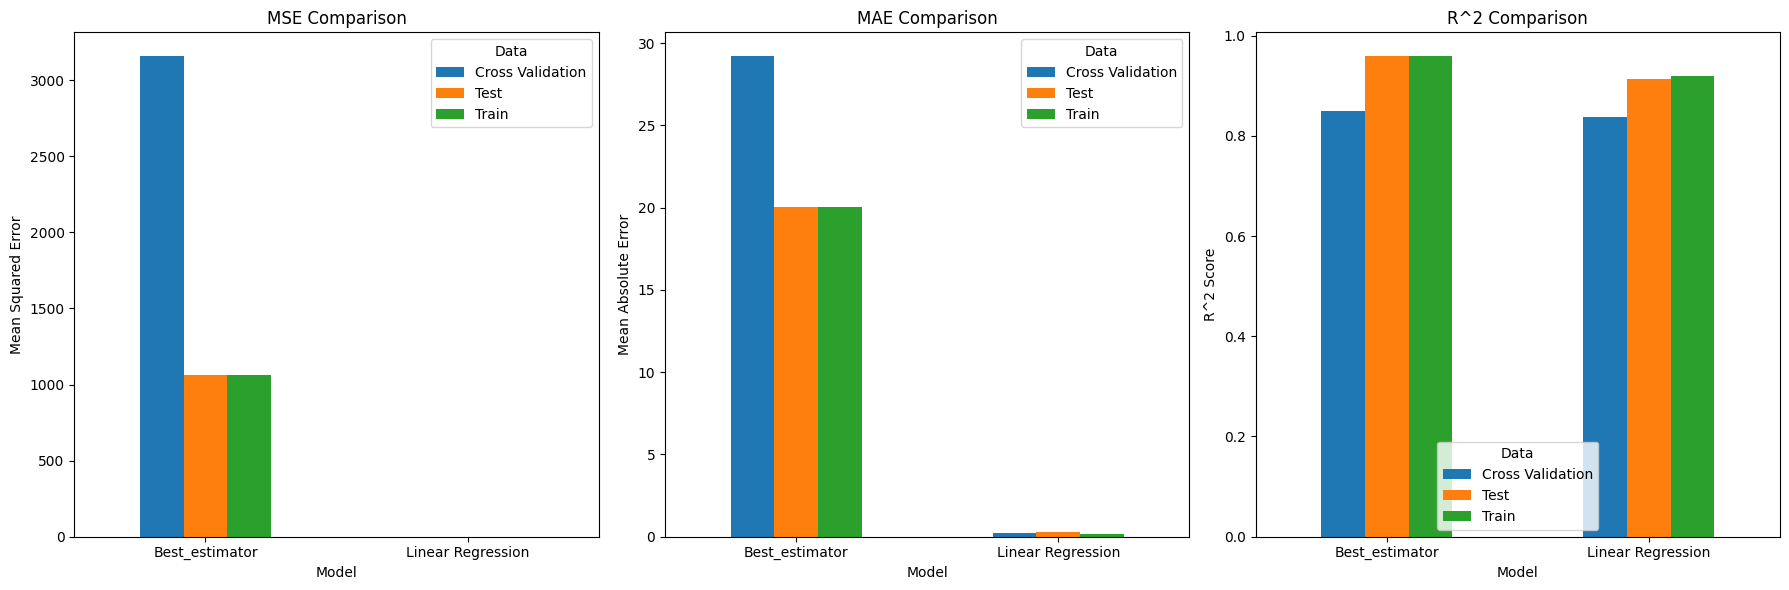

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# 데이터 프레임 생성 및 출력
data = {
    'Model': ['Linear Regression', 'Linear Regression', 'Linear Regression', 'Best_estimator', 'Best_estimator', 'Best_estimator'],
    'Data': ['Train', 'Test', 'Cross Validation', 'Train', 'Test', 'Cross Validation'],
    'MSE': [0.0801224583554283, 0.24803230657316613, 0.13181727363348067, 1060.0886995073975, 1060.0886995073975, 3157.8033302611766],
    'MAE': [0.16804937927784483, 0.26392149188229946, 0.19030180099662164, 20.027128576417034, 20.027128576417034, 29.19542792940276],
    'R^2': [0.9198775416445717, 0.9135338794627539, 0.8367981229997092, 0.9588199307050851, 0.9588199307050851, 0.850323331957617]
}

df = pd.DataFrame(data)
print(df)
print()

# 데이터 bar 차트로 시각화
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

# MSE 바 차트
df_mse = df.pivot(index='Model', columns='Data', values='MSE')
df_mse.plot(kind='bar', ax=axes[0])
axes[0].set_title('MSE Comparison')
axes[0].set_ylabel('Mean Squared Error')
axes[0].set_xlabel('Model')
axes[0].tick_params(axis='x', rotation=0)

# MAE 바 차트
df_mae = df.pivot(index='Model', columns='Data', values='MAE')
df_mae.plot(kind='bar', ax=axes[1])
axes[1].set_title('MAE Comparison')
axes[1].set_ylabel('Mean Absolute Error')
axes[1].set_xlabel('Model')
axes[1].tick_params(axis='x', rotation=0)

# R^2 바 차트
df_r2 = df.pivot(index='Model', columns='Data', values='R^2')
df_r2.plot(kind='bar', ax=axes[2])
axes[2].set_title('R^2 Comparison')
axes[2].set_ylabel('R^2 Score')
axes[2].set_xlabel('Model')
axes[2].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()
